# Tutorial

Make sure that you have done a [proper installation of pysrim and SRIM](https://pysrim.readthedocs.io/en/latest/installation.html)

This means that you have SRIM 2013 installed. **NOT 2018**.

In this tutorial we will cover:
  - running a TRIM calcualtion
  - running a SR calculation
  - analyzing TRIM calculation output files
  
Most emphasis will be put on what is possible for analysis of SRIM calcualtions.

We will assume **python3** for this notebook.

In [1]:
%matplotlib inline

import os
from pprint import pprint

# Only needed to embed the images in notebook
from IPython.display import Image

import numpy as np
import matplotlib.pyplot as plt

from srim import TRIM, SR, Ion, Layer, Target
from srim.output import Results

# Run a SRIM Calculation

Running a srim calculation is much like the gui that SRIM provides.

Concepts:
  - a list of Layers forms a Target
  - a Layer is a dict of elements, with density, and a width
  - an Element can be specified by symbol, atomic number, or name, with a custom mass [amu]
  - an Ion is like an Element except that it also requires an energy in [eV]

In [3]:
# Construct a 3MeV Nickel ion
ion = Ion('Ni', energy=3.0e6)

# Construct a layer of nick 20um thick with a displacement energy of 30 eV
layer = Layer({
        'Ni': {
            'stoich': 1.0, 
            'E_d': 30.0, 
            'lattice': 0.0, 
            'surface': 3.0
        },
}, density=8.9, width=20000.0)

# Construct a target of a single layer of Nickel
target = Target([layer])

# Initialize a TRIM calculation with given target and ion for 25 ions, quick calculation
trim = TRIM(target, ion, number_ions=500, calculation=1)

# Specify the directory of SRIM.exe
# For windows users the path will include C://...
# The directory must have SRIM 2013 installed. TRIM.exe should be in this folder
srim_executable_directory = '/tmp/srim' 

# takes about 10 seconds on my laptop
results = trim.run(srim_executable_directory)
# If all went successfull you should have seen a TRIM window popup and run 25 ions!

The results variable contains dictionary of automatically parsed TRIM output files.

If you needed to get the results later. Suppose you no longer had the results variable.
The results from the calculation were written to the `srim_executable_directory`, `/tmp/srim` in this case.

In [13]:
# equivalent to results variable gotten from `trim.run`
srim_executable_directory = '/tmp/srim' 
results = Results(srim_executable_directory)

In [14]:
print('Number of Ions: {}'.format(results.ioniz.num_ions))
results.__dict__

Number of Ions: 500


{'ioniz': <srim.output.Ioniz at 0x7f95c3459a90>,
 'vacancy': <srim.output.Vacancy at 0x7f95c3459da0>,
 'novac': None,
 'etorecoils': <srim.output.EnergyToRecoils at 0x7f95c34545c0>,
 'phonons': <srim.output.Phonons at 0x7f95c33e39e8>,
 'range': <srim.output.Range at 0x7f95ec648a90>}

# Copy SRIM files
Helper function to copy SRIM files from one directory to another. Covers all of the output files.

In [16]:
output_directory = '/tmp/srim_outputs'
os.makedirs(output_directory, exist_ok=True)
print('Before:', os.listdir(output_directory))
TRIM.copy_output_files('/tmp/srim', output_directory)
print('After:', os.listdir(output_directory))

Before: []
After: ['TRIM.IN', 'LATERAL.txt', 'COLLISON.txt', 'NOVAC.txt', 'TDATA.txt', 'E2RECOIL.txt', 'VACANCY.txt', 'RANGE.txt', 'IONIZ.txt', 'PHONON.txt']


# Problem 1
Calculate the damage energy

In [6]:
def plot_damage_energy(results, ax):
    phon = results.phonons
    dx = max(phon.depth) / 100.0 # to units of Angstroms
    energy_damage = (phon.ions + phon.recoils) * dx
    ax.plot(phon.depth, energy_damage / phon.num_ions, label="damage")
    return sum(energy_damage)

def plot_ionization(results, ax):
    ioniz = results.ioniz
    dx = max(ioniz.depth) / 100.0 # to units of Angstroms
    ax.plot(ioniz.depth, ioniz.ions, label='Ionization from Ions')
    ax.plot(ioniz.depth, ioniz.recoils, label='Ionization from Recoils')
    
def plot_vacancies(results, ax):
    vac = results.vacancy
    vacancy_depth = vac.knock_ons + np.sum(vac.vacancies, axis=1)
    ax.plot(vac.depth, vacancy_depth, label="Total vacancies at depth")
    return sum(vacancy_depth)

image_directory = '../images'

Damage energy: 909972.9860200001 eV


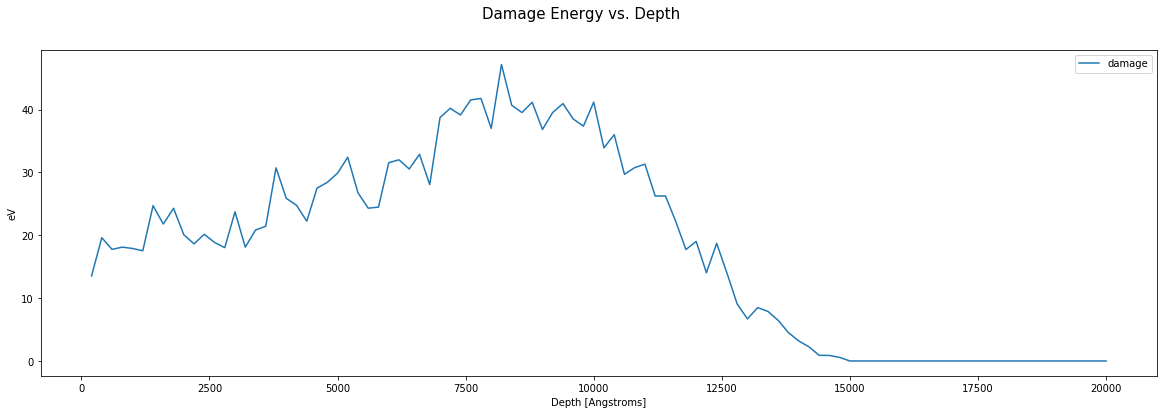

In [7]:
fig, ax = plt.subplots()
energy_damage = plot_damage_energy(results, ax)
print("Damage energy: {} eV".format(energy_damage))
ax.set_xlabel('Depth [Angstroms]')
ax.set_ylabel('eV')
ax.legend()

fig.suptitle('Damage Energy vs. Depth', fontsize=15)
fig.set_size_inches((20, 6))
fig.savefig(os.path.join(image_directory, 'damagevsdepth.png'), transparent=True)

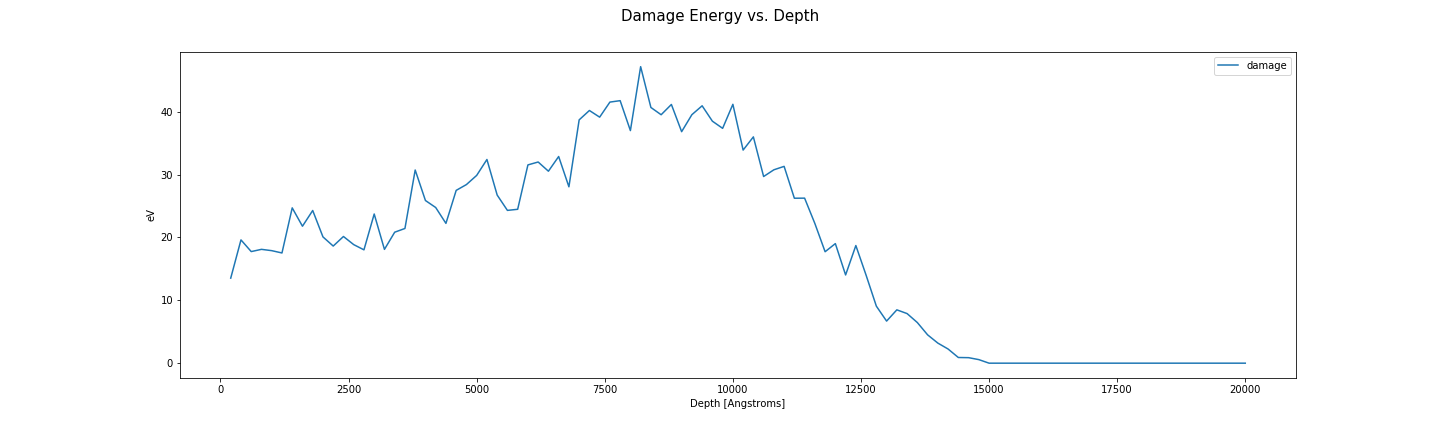

In [8]:
Image(filename=os.path.join(image_directory, 'damagevsdepth.png'))

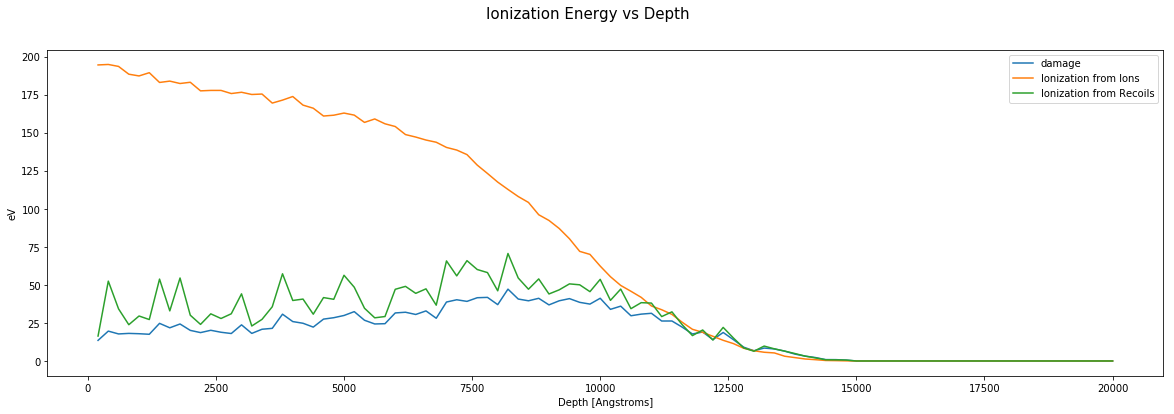

In [9]:
fig, ax = plt.subplots()

plot_damage_energy(results, ax)
plot_ionization(results, ax)
ax.legend()
ax.set_ylabel('eV')
ax.set_xlabel('Depth [Angstroms]')
fig.suptitle('Ionization Energy vs Depth', fontsize=15)
fig.set_size_inches((20, 6))
fig.savefig(os.path.join(image_directory, 'ionizationvsdepth.png'), transparent=True)

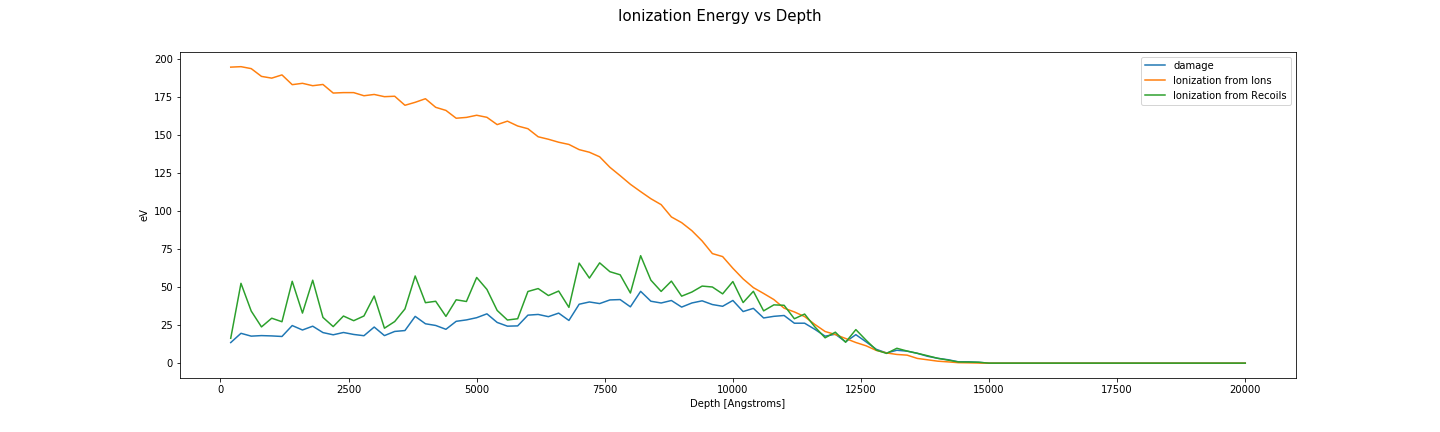

In [10]:
Image(filename=os.path.join(image_directory, 'ionizationvsdepth.png'))

Total number of vacancies: 60.053133499999994


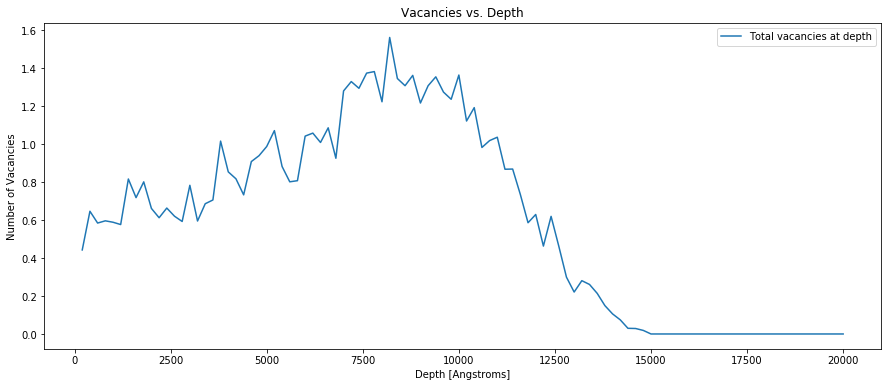

In [11]:
fig, ax = plt.subplots()

total_vacancies = plot_vacancies(results, ax)
print("Total number of vacancies: {}".format(total_vacancies))

ax.set_xlabel('Depth [Angstroms]')
ax.set_ylabel('Number of Vacancies')
ax.set_title('Vacancies vs. Depth')
ax.legend()
fig.set_size_inches((15, 6))
fig.savefig(os.path.join(image_directory, 'vacanciesvsdepth.png'), transparent=True)

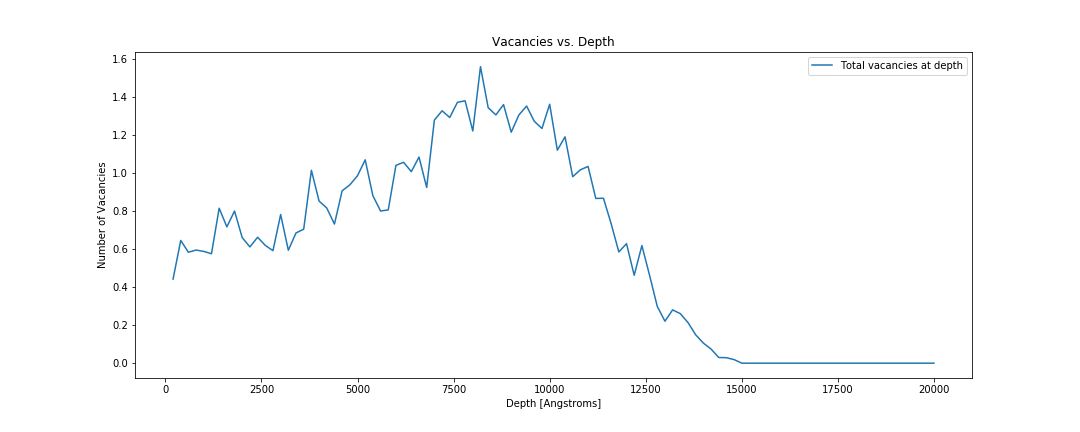

In [12]:
Image(filename=os.path.join(image_directory, 'vacanciesvsdepth.png'))